In [1]:
import os
import cv2
import math
import time
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
from tqdm import tqdm
from pathlib import Path
import torch.optim as optim
from torchinfo import summary
from datetime import timedelta
from functools import lru_cache
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    matthews_corrcoef, confusion_matrix, classification_report
)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
train_df = pd.read_csv(
    "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv"
)

In [6]:
df = (
    train_df
    .groupby("patientId")["Target"]
    .max()
    .reset_index()
    .rename(columns={"Target": "label"})
)



In [7]:
from sklearn.model_selection import train_test_split


train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    stratify=df["label"],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df["label"],
    random_state=42
)

print("Train:", train_df.shape)
print("Val:", val_df.shape)
print("Test:", test_df.shape)


Train: (18678, 2)
Val: (4003, 2)
Test: (4003, 2)


In [8]:
import os
import pydicom
import numpy as np
import random

TRAIN_IMG_DIR = "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images"


In [9]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import timm


from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, f1_score,
    roc_auc_score, confusion_matrix,
    classification_report, roc_curve
)

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [10]:
class RSNADataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        pid = self.df.loc[idx, "patientId"]
        label = self.df.loc[idx, "label"]

        path = os.path.join(self.img_dir, pid + ".dcm")
        dcm = pydicom.dcmread(path)
        img = dcm.pixel_array

        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
        img = np.stack([img]*3, axis=-1).astype(np.uint8)

        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.float32)


In [11]:
BATCH_SIZE = 16

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    
    transforms.ToTensor(),
])

In [12]:
train_loader = DataLoader(
    RSNADataset(train_df, TRAIN_IMG_DIR, transform),
    batch_size=BATCH_SIZE, shuffle=True, num_workers=2
)

val_loader = DataLoader(
    RSNADataset(val_df, TRAIN_IMG_DIR, transform),
    batch_size=BATCH_SIZE, shuffle=False, num_workers=2
)

test_loader = DataLoader(
    RSNADataset(test_df, TRAIN_IMG_DIR, transform),
    batch_size=BATCH_SIZE, shuffle=False, num_workers=2
)

In [13]:
train_steps = len(train_loader)
val_steps = len(val_loader)
test_steps = len(test_loader)

In [14]:
class PneuNet(nn.Module):
    def __init__(self, freeze_backbone=False, input_channels=1, use_80_tokens=True):
        super(PneuNet, self).__init__()

        # Load pretrained ResNet-18
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

        # Modify first conv if grayscale
        if input_channels != 3:
            resnet.conv1 = nn.Conv2d(
                input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False
            )

        # Backbone
        self.backbone = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
            resnet.layer4,
        )

        if freeze_backbone:
            for p in self.backbone.parameters():
                p.requires_grad = False

        self.post_resnet_bn = nn.BatchNorm2d(512)

        # Token configuration
        if use_80_tokens:
            self.adaptive_pool = nn.AdaptiveAvgPool2d((10, 8))
            token_count = 80
        else:
            self.adaptive_pool = nn.Identity()
            token_count = 49

        # Transformer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=512,
            nhead=8,
            dim_feedforward=2048,
            dropout=0.1,
            activation="relu",
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=6
        )

        self.layer_norm = nn.LayerNorm(512)

        # Binary MLP head
        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(token_count * 512, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(16, 1)   # 

    def forward(self, x):
        x = self.backbone(x)
        x = self.post_resnet_bn(x)
        x = self.adaptive_pool(x)

        b, c, h, w = x.shape
        x = x.view(b, c, h * w).permute(0, 2, 1)

        x = self.transformer_encoder(x)
        x = self.layer_norm(x)

        logits = self.mlp(x)   # [B, 1]
        return logits


In [15]:
model = PneuNet(
    freeze_backbone=True,
    input_channels=3,
    use_80_tokens=True
)

model = model.to(device)
summary(model, (1, 3, 224, 224))


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 190MB/s]


Layer (type:depth-idx)                        Output Shape              Param #
PneuNet                                       [1, 1]                    --
├─Sequential: 1-1                             [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                            [1, 64, 112, 112]         (9,408)
│    └─BatchNorm2d: 2-2                       [1, 64, 112, 112]         (128)
│    └─ReLU: 2-3                              [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                         [1, 64, 56, 56]           --
│    └─Sequential: 2-5                        [1, 64, 56, 56]           --
│    │    └─BasicBlock: 3-1                   [1, 64, 56, 56]           (73,984)
│    │    └─BasicBlock: 3-2                   [1, 64, 56, 56]           (73,984)
│    └─Sequential: 2-6                        [1, 128, 28, 28]          --
│    │    └─BasicBlock: 3-3                   [1, 128, 28, 28]          (230,144)
│    │    └─BasicBlock: 3-4                   [1, 128, 28, 28]      

In [16]:
import torch
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    matthews_corrcoef,
    roc_auc_score
)

def custom_metrics(y_logits, y_true, loss, threshold=0.5):
    """
    Custom evaluation metrics for BINARY classification.

    Args:
        y_logits (Tensor): Raw logits from model, shape [B, 1]
        y_true (Tensor): Ground truth labels, shape [B] or [B, 1]
        loss (float): Loss value
        threshold (float): Probability threshold for classification

    Returns:
        dict: Dictionary containing computed metrics
    """

    # Ensure proper shapes
    y_true = y_true.view(-1).cpu().numpy()
    y_probs = torch.sigmoid(y_logits).view(-1).cpu().numpy()
    y_pred = (y_probs >= threshold).astype(int)

    # Core metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    # Confusion matrix: [[TN, FP], [FN, TP]]
    cm = confusion_matrix(y_true, y_pred)

    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp + 1e-8)
        sensitivity = tp / (tp + fn + 1e-8)
    else:
        specificity = 0.0
        sensitivity = 0.0

    # MCC
    mcc = matthews_corrcoef(y_true, y_pred)

    # AUC (single score for binary)
    try:
        auc = roc_auc_score(y_true, y_probs)
    except ValueError:
        auc = 0.0  # occurs if only one class present in batch

    metrics = {
        "loss": loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "specificity": specificity,
        "sensitivity": sensitivity,
        "mcc": mcc,
        "auc": auc,
    }

    return metrics


In [17]:
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.AdamW(
    model.parameters(),
    lr=1e-4,
    weight_decay=1e-5
)

scheduler = torch.optim.lr_scheduler.ExponentialLR(
    optimizer,
    gamma=0.995
)


In [19]:
# Metrics initialization
metric_names = ["loss", "accuracy", "precision", "recall", "f1_score",
                "specificity", "sensitivity", "mcc", "auc"]
train_metrics_history = {metric_name: [] for metric_name in metric_names}
val_metrics_history = {metric_name: [] for metric_name in metric_names}

num_epochs = 25
total_training_time = 0.0
total_validation_time = 0.0

In [20]:


for epoch in range(num_epochs):
    start_time = time.time()

    # ===================== TRAIN =====================
    model.train()
    total_loss = 0.0
    all_logits = []
    all_targets = []

    for data, targets in tqdm(train_loader, desc=f"Training Epoch [{epoch+1}/{num_epochs}]"):
        data = data.to(device)
        targets = targets.to(device).float().unsqueeze(1)  # 

        optimizer.zero_grad()
        outputs = model(data)                               # [B, 1]
        loss = criterion(outputs, targets)                  # 
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        all_logits.append(outputs.detach().cpu())           # 
        all_targets.append(targets.detach().cpu())          # 

    epoch_training_time = time.time() - start_time
    total_training_time += epoch_training_time

    avg_train_loss = total_loss / len(train_loader)
    all_logits = torch.cat(all_logits, dim=0)               # [N, 1]
    all_targets = torch.cat(all_targets, dim=0)             # [N, 1]

    train_metrics = custom_metrics(all_logits, all_targets, avg_train_loss)

    print("Train Metrics - " + ", ".join(
        f"{k}: {v:.4f}" for k, v in train_metrics.items()
    ))

    for k in metric_names:
        train_metrics_history[k].append(train_metrics[k])

    # ===================== VALIDATION =====================
    model.eval()
    total_loss = 0.0
    all_logits = []
    all_targets = []
    start_time = time.time()

    with torch.no_grad():
        for data, targets in tqdm(val_loader, desc="Validating"):
            data = data.to(device)
            targets = targets.to(device).float().unsqueeze(1)  # 

            outputs = model(data)
            loss = criterion(outputs, targets)                 # 
            total_loss += loss.item()

            all_logits.append(outputs.detach().cpu())          # 
            all_targets.append(targets.detach().cpu())         # 

    epoch_validation_time = time.time() - start_time
    total_validation_time += epoch_validation_time

    avg_val_loss = total_loss / len(val_loader)
    all_logits = torch.cat(all_logits, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    val_metrics = custom_metrics(all_logits, all_targets, avg_val_loss)

    print("Val Metrics   - " + ", ".join(
        f"{k}: {v:.4f}" for k, v in val_metrics.items()
    ))

    for k in metric_names:
        val_metrics_history[k].append(val_metrics[k])

    scheduler.step()

print(f"Total Training Time: {str(timedelta(seconds=total_training_time))}")
print(f"Total Validation Time: {str(timedelta(seconds=total_validation_time))}")


Training Epoch [1/25]: 100%|██████████| 1168/1168 [02:42<00:00,  7.18it/s]


Train Metrics - loss: 0.5090, accuracy: 0.7686, precision: 0.2763, recall: 0.0169, f1_score: 0.0318, specificity: 0.9871, sensitivity: 0.0169, mcc: 0.0144, auc: 0.6912


Validating: 100%|██████████| 251/251 [01:00<00:00,  4.13it/s]


Val Metrics   - loss: 0.4728, accuracy: 0.7747, precision: 0.0000, recall: 0.0000, f1_score: 0.0000, specificity: 1.0000, sensitivity: 0.0000, mcc: 0.0000, auc: 0.6912


Training Epoch [2/25]: 100%|██████████| 1168/1168 [02:42<00:00,  7.20it/s]


Train Metrics - loss: 0.5001, accuracy: 0.7734, precision: 0.3810, recall: 0.0095, f1_score: 0.0185, specificity: 0.9955, sensitivity: 0.0095, mcc: 0.0280, auc: 0.6966


Validating: 100%|██████████| 251/251 [00:32<00:00,  7.61it/s]


Val Metrics   - loss: 0.4618, accuracy: 0.7747, precision: 0.0000, recall: 0.0000, f1_score: 0.0000, specificity: 1.0000, sensitivity: 0.0000, mcc: 0.0000, auc: 0.7612


Training Epoch [3/25]: 100%|██████████| 1168/1168 [02:42<00:00,  7.19it/s]


Train Metrics - loss: 0.5027, accuracy: 0.7740, precision: 0.4316, recall: 0.0097, f1_score: 0.0191, specificity: 0.9963, sensitivity: 0.0097, mcc: 0.0353, auc: 0.6994


Validating: 100%|██████████| 251/251 [00:33<00:00,  7.58it/s]


Val Metrics   - loss: 0.5050, accuracy: 0.7747, precision: 0.0000, recall: 0.0000, f1_score: 0.0000, specificity: 1.0000, sensitivity: 0.0000, mcc: 0.0000, auc: 0.7311


Training Epoch [4/25]: 100%|██████████| 1168/1168 [02:41<00:00,  7.22it/s]


Train Metrics - loss: 0.5228, accuracy: 0.7745, precision: 0.2000, recall: 0.0002, f1_score: 0.0005, specificity: 0.9997, sensitivity: 0.0002, mcc: -0.0010, auc: 0.6143


Validating: 100%|██████████| 251/251 [00:33<00:00,  7.55it/s]


Val Metrics   - loss: 0.5166, accuracy: 0.7747, precision: 0.0000, recall: 0.0000, f1_score: 0.0000, specificity: 1.0000, sensitivity: 0.0000, mcc: 0.0000, auc: 0.5912


Training Epoch [5/25]: 100%|██████████| 1168/1168 [02:40<00:00,  7.27it/s]


Train Metrics - loss: 0.5279, accuracy: 0.7746, precision: 0.0000, recall: 0.0000, f1_score: 0.0000, specificity: 0.9999, sensitivity: 0.0000, mcc: -0.0056, auc: 0.5970


Validating: 100%|██████████| 251/251 [00:33<00:00,  7.56it/s]


Val Metrics   - loss: 0.5536, accuracy: 0.7747, precision: 0.0000, recall: 0.0000, f1_score: 0.0000, specificity: 1.0000, sensitivity: 0.0000, mcc: 0.0000, auc: 0.6011


Training Epoch [6/25]: 100%|██████████| 1168/1168 [02:51<00:00,  6.80it/s]


Train Metrics - loss: 0.5512, accuracy: 0.7747, precision: 0.0000, recall: 0.0000, f1_score: 0.0000, specificity: 1.0000, sensitivity: 0.0000, mcc: 0.0000, auc: 0.5089


Validating: 100%|██████████| 251/251 [00:36<00:00,  6.94it/s]


Val Metrics   - loss: 0.5461, accuracy: 0.7747, precision: 0.0000, recall: 0.0000, f1_score: 0.0000, specificity: 1.0000, sensitivity: 0.0000, mcc: 0.0000, auc: 0.7120


Training Epoch [7/25]: 100%|██████████| 1168/1168 [02:55<00:00,  6.65it/s]


Train Metrics - loss: 0.5511, accuracy: 0.7747, precision: 0.0000, recall: 0.0000, f1_score: 0.0000, specificity: 1.0000, sensitivity: 0.0000, mcc: 0.0000, auc: 0.4970


Validating: 100%|██████████| 251/251 [00:36<00:00,  6.81it/s]


Val Metrics   - loss: 0.5413, accuracy: 0.7747, precision: 0.0000, recall: 0.0000, f1_score: 0.0000, specificity: 1.0000, sensitivity: 0.0000, mcc: 0.0000, auc: 0.5866


Training Epoch [8/25]: 100%|██████████| 1168/1168 [02:53<00:00,  6.73it/s]


Train Metrics - loss: 0.5476, accuracy: 0.7747, precision: 0.0000, recall: 0.0000, f1_score: 0.0000, specificity: 1.0000, sensitivity: 0.0000, mcc: 0.0000, auc: 0.5037


Validating: 100%|██████████| 251/251 [00:35<00:00,  7.05it/s]


Val Metrics   - loss: 0.5423, accuracy: 0.7747, precision: 0.0000, recall: 0.0000, f1_score: 0.0000, specificity: 1.0000, sensitivity: 0.0000, mcc: 0.0000, auc: 0.5228


Training Epoch [9/25]: 100%|██████████| 1168/1168 [03:06<00:00,  6.27it/s]


Train Metrics - loss: 0.5467, accuracy: 0.7747, precision: 0.0000, recall: 0.0000, f1_score: 0.0000, specificity: 1.0000, sensitivity: 0.0000, mcc: 0.0000, auc: 0.5010


Validating: 100%|██████████| 251/251 [00:38<00:00,  6.47it/s]


Val Metrics   - loss: 0.5403, accuracy: 0.7747, precision: 0.0000, recall: 0.0000, f1_score: 0.0000, specificity: 1.0000, sensitivity: 0.0000, mcc: 0.0000, auc: 0.5462


Training Epoch [10/25]: 100%|██████████| 1168/1168 [03:06<00:00,  6.26it/s]


Train Metrics - loss: 0.5446, accuracy: 0.7747, precision: 0.0000, recall: 0.0000, f1_score: 0.0000, specificity: 1.0000, sensitivity: 0.0000, mcc: 0.0000, auc: 0.5088


Validating: 100%|██████████| 251/251 [00:38<00:00,  6.54it/s]


Val Metrics   - loss: 0.5454, accuracy: 0.7747, precision: 0.0000, recall: 0.0000, f1_score: 0.0000, specificity: 1.0000, sensitivity: 0.0000, mcc: 0.0000, auc: 0.5792


Training Epoch [11/25]: 100%|██████████| 1168/1168 [03:06<00:00,  6.25it/s]


Train Metrics - loss: 0.5454, accuracy: 0.7747, precision: 0.0000, recall: 0.0000, f1_score: 0.0000, specificity: 1.0000, sensitivity: 0.0000, mcc: 0.0000, auc: 0.4982


Validating: 100%|██████████| 251/251 [00:38<00:00,  6.52it/s]


Val Metrics   - loss: 0.5421, accuracy: 0.7747, precision: 0.0000, recall: 0.0000, f1_score: 0.0000, specificity: 1.0000, sensitivity: 0.0000, mcc: 0.0000, auc: 0.5000


Training Epoch [12/25]: 100%|██████████| 1168/1168 [03:06<00:00,  6.26it/s]


Train Metrics - loss: 0.5446, accuracy: 0.7747, precision: 0.0000, recall: 0.0000, f1_score: 0.0000, specificity: 1.0000, sensitivity: 0.0000, mcc: 0.0000, auc: 0.4953


Validating: 100%|██████████| 251/251 [00:38<00:00,  6.45it/s]


Val Metrics   - loss: 0.5426, accuracy: 0.7747, precision: 0.0000, recall: 0.0000, f1_score: 0.0000, specificity: 1.0000, sensitivity: 0.0000, mcc: 0.0000, auc: 0.5000


Training Epoch [13/25]: 100%|██████████| 1168/1168 [03:08<00:00,  6.20it/s]


Train Metrics - loss: 0.5433, accuracy: 0.7747, precision: 0.0000, recall: 0.0000, f1_score: 0.0000, specificity: 1.0000, sensitivity: 0.0000, mcc: 0.0000, auc: 0.4955


Validating: 100%|██████████| 251/251 [00:38<00:00,  6.46it/s]


Val Metrics   - loss: 0.5382, accuracy: 0.7747, precision: 0.0000, recall: 0.0000, f1_score: 0.0000, specificity: 1.0000, sensitivity: 0.0000, mcc: 0.0000, auc: 0.4483


Training Epoch [14/25]: 100%|██████████| 1168/1168 [03:06<00:00,  6.25it/s]


Train Metrics - loss: 0.5412, accuracy: 0.7747, precision: 0.0000, recall: 0.0000, f1_score: 0.0000, specificity: 1.0000, sensitivity: 0.0000, mcc: 0.0000, auc: 0.5027


Validating: 100%|██████████| 251/251 [00:38<00:00,  6.55it/s]


Val Metrics   - loss: 0.5392, accuracy: 0.7747, precision: 0.0000, recall: 0.0000, f1_score: 0.0000, specificity: 1.0000, sensitivity: 0.0000, mcc: 0.0000, auc: 0.5000


Training Epoch [15/25]: 100%|██████████| 1168/1168 [03:07<00:00,  6.24it/s]


Train Metrics - loss: 0.5418, accuracy: 0.7747, precision: 0.0000, recall: 0.0000, f1_score: 0.0000, specificity: 1.0000, sensitivity: 0.0000, mcc: 0.0000, auc: 0.5001


Validating: 100%|██████████| 251/251 [00:38<00:00,  6.60it/s]


Val Metrics   - loss: 0.5401, accuracy: 0.7747, precision: 0.0000, recall: 0.0000, f1_score: 0.0000, specificity: 1.0000, sensitivity: 0.0000, mcc: 0.0000, auc: 0.5000


Training Epoch [16/25]: 100%|██████████| 1168/1168 [03:05<00:00,  6.29it/s]


Train Metrics - loss: 0.5414, accuracy: 0.7747, precision: 0.0000, recall: 0.0000, f1_score: 0.0000, specificity: 1.0000, sensitivity: 0.0000, mcc: 0.0000, auc: 0.4989


Validating: 100%|██████████| 251/251 [00:39<00:00,  6.42it/s]


Val Metrics   - loss: 0.5365, accuracy: 0.7747, precision: 0.0000, recall: 0.0000, f1_score: 0.0000, specificity: 1.0000, sensitivity: 0.0000, mcc: 0.0000, auc: 0.5000


Training Epoch [17/25]: 100%|██████████| 1168/1168 [03:04<00:00,  6.32it/s]


Train Metrics - loss: 0.5404, accuracy: 0.7747, precision: 0.0000, recall: 0.0000, f1_score: 0.0000, specificity: 1.0000, sensitivity: 0.0000, mcc: 0.0000, auc: 0.5006


Validating: 100%|██████████| 251/251 [00:38<00:00,  6.56it/s]


Val Metrics   - loss: 0.5428, accuracy: 0.7747, precision: 0.0000, recall: 0.0000, f1_score: 0.0000, specificity: 1.0000, sensitivity: 0.0000, mcc: 0.0000, auc: 0.5885


Training Epoch [18/25]: 100%|██████████| 1168/1168 [03:05<00:00,  6.28it/s]


Train Metrics - loss: 0.5394, accuracy: 0.7747, precision: 0.0000, recall: 0.0000, f1_score: 0.0000, specificity: 1.0000, sensitivity: 0.0000, mcc: 0.0000, auc: 0.5005


Validating: 100%|██████████| 251/251 [00:38<00:00,  6.52it/s]


Val Metrics   - loss: 0.5383, accuracy: 0.7747, precision: 0.0000, recall: 0.0000, f1_score: 0.0000, specificity: 1.0000, sensitivity: 0.0000, mcc: 0.0000, auc: 0.5000


Training Epoch [19/25]: 100%|██████████| 1168/1168 [03:06<00:00,  6.26it/s]


Train Metrics - loss: 0.5402, accuracy: 0.7747, precision: 0.0000, recall: 0.0000, f1_score: 0.0000, specificity: 1.0000, sensitivity: 0.0000, mcc: 0.0000, auc: 0.4932


Validating: 100%|██████████| 251/251 [00:38<00:00,  6.54it/s]


Val Metrics   - loss: 0.5397, accuracy: 0.7747, precision: 0.0000, recall: 0.0000, f1_score: 0.0000, specificity: 1.0000, sensitivity: 0.0000, mcc: 0.0000, auc: 0.4883


Training Epoch [20/25]: 100%|██████████| 1168/1168 [03:08<00:00,  6.19it/s]


Train Metrics - loss: 0.5401, accuracy: 0.7747, precision: 0.0000, recall: 0.0000, f1_score: 0.0000, specificity: 1.0000, sensitivity: 0.0000, mcc: 0.0000, auc: 0.4902


Validating: 100%|██████████| 251/251 [00:40<00:00,  6.14it/s]


Val Metrics   - loss: 0.5405, accuracy: 0.7747, precision: 0.0000, recall: 0.0000, f1_score: 0.0000, specificity: 1.0000, sensitivity: 0.0000, mcc: 0.0000, auc: 0.5000


Training Epoch [21/25]: 100%|██████████| 1168/1168 [03:16<00:00,  5.95it/s]


Train Metrics - loss: 0.5387, accuracy: 0.7747, precision: 0.0000, recall: 0.0000, f1_score: 0.0000, specificity: 1.0000, sensitivity: 0.0000, mcc: 0.0000, auc: 0.4966


Validating: 100%|██████████| 251/251 [00:40<00:00,  6.21it/s]


Val Metrics   - loss: 0.5380, accuracy: 0.7747, precision: 0.0000, recall: 0.0000, f1_score: 0.0000, specificity: 1.0000, sensitivity: 0.0000, mcc: 0.0000, auc: 0.4764


Training Epoch [22/25]: 100%|██████████| 1168/1168 [03:12<00:00,  6.08it/s]


Train Metrics - loss: 0.5376, accuracy: 0.7747, precision: 0.0000, recall: 0.0000, f1_score: 0.0000, specificity: 1.0000, sensitivity: 0.0000, mcc: 0.0000, auc: 0.5020


Validating: 100%|██████████| 251/251 [00:39<00:00,  6.38it/s]


Val Metrics   - loss: 0.5366, accuracy: 0.7747, precision: 0.0000, recall: 0.0000, f1_score: 0.0000, specificity: 1.0000, sensitivity: 0.0000, mcc: 0.0000, auc: 0.4354


Training Epoch [23/25]: 100%|██████████| 1168/1168 [03:05<00:00,  6.31it/s]


Train Metrics - loss: 0.5375, accuracy: 0.7747, precision: 0.0000, recall: 0.0000, f1_score: 0.0000, specificity: 1.0000, sensitivity: 0.0000, mcc: 0.0000, auc: 0.5008


Validating: 100%|██████████| 251/251 [00:37<00:00,  6.64it/s]


Val Metrics   - loss: 0.5356, accuracy: 0.7747, precision: 0.0000, recall: 0.0000, f1_score: 0.0000, specificity: 1.0000, sensitivity: 0.0000, mcc: 0.0000, auc: 0.5000


Training Epoch [24/25]: 100%|██████████| 1168/1168 [03:07<00:00,  6.21it/s]


Train Metrics - loss: 0.5377, accuracy: 0.7747, precision: 0.0000, recall: 0.0000, f1_score: 0.0000, specificity: 1.0000, sensitivity: 0.0000, mcc: 0.0000, auc: 0.4941


Validating: 100%|██████████| 251/251 [00:39<00:00,  6.42it/s]


Val Metrics   - loss: 0.5390, accuracy: 0.7747, precision: 0.0000, recall: 0.0000, f1_score: 0.0000, specificity: 1.0000, sensitivity: 0.0000, mcc: 0.0000, auc: 0.4998


Training Epoch [25/25]: 100%|██████████| 1168/1168 [03:07<00:00,  6.23it/s]


Train Metrics - loss: 0.5376, accuracy: 0.7747, precision: 0.0000, recall: 0.0000, f1_score: 0.0000, specificity: 1.0000, sensitivity: 0.0000, mcc: 0.0000, auc: 0.4963


Validating: 100%|██████████| 251/251 [00:38<00:00,  6.49it/s]

Val Metrics   - loss: 0.5376, accuracy: 0.7747, precision: 0.0000, recall: 0.0000, f1_score: 0.0000, specificity: 1.0000, sensitivity: 0.0000, mcc: 0.0000, auc: 0.4914
Total Training Time: 1:15:20.630563
Total Validation Time: 0:16:02.331453


In [21]:
import math
import matplotlib.pyplot as plt

def plot_metrics(train_metrics_history, val_metrics_history, metric_names):
    """
    Plots training and validation metrics per epoch (binary classification safe).
    """
    num_metrics = len(metric_names)
    num_epochs = len(train_metrics_history[metric_names[0]])

    fig, axes = plt.subplots(num_metrics, figsize=(10, 5 * num_metrics))
    rng = range(1, num_epochs + 1)

    for ax, metric_name in zip(axes, metric_names):
        train_metric = train_metrics_history[metric_name]
        val_metric = val_metrics_history[metric_name]

        ax.plot(rng, train_metric, label="Training", marker="o")
        ax.plot(rng, val_metric, label="Validation", marker="s")
        ax.legend()
        ax.set_xlabel("Epochs")

        title = metric_name.upper() if metric_name in ("auc", "mcc") else metric_name.capitalize()
        ax.set_title(f"{title} vs Epochs")
        ax.set_ylabel(title)

       
        if metric_name == "loss":
            y_min = min(min(train_metric), min(val_metric))
            y_max = max(max(train_metric), max(val_metric))
            ax.set_ylim(y_min * 0.9, y_max * 1.1)

        elif metric_name == "mcc":
            ax.set_ylim(-1.0, 1.0)

        else:  # All probability-based metrics
            ax.set_ylim(0.0, 1.0)

        ax.set_xlim(1, num_epochs)
        ax.grid(True, linestyle="--", alpha=0.5)

    plt.tight_layout()
    plt.show()


In [22]:
model.eval()
total_loss = 0.0
all_logits = []
all_targets = []

with torch.no_grad():
    for data, targets in tqdm(test_loader, desc="Testing Model"):
        data = data.to(device)
        targets = targets.to(device).float().unsqueeze(1)   # 

        outputs = model(data)                               # [B, 1]
        loss = criterion(outputs, targets)                  # 
        total_loss += loss.item()

        all_logits.append(outputs.detach().cpu())           # 
        all_targets.append(targets.detach().cpu())          # 

# Concatenate once (keeps shape correct)
all_logits = torch.cat(all_logits, dim=0)                   # [N, 1]
all_targets = torch.cat(all_targets, dim=0)                 # [N, 1]

average_loss = total_loss / len(test_loader)

test_metrics = custom_metrics(all_logits, all_targets, average_loss)

testing_metrics_line = "Test Metrics - "
testing_metrics_line += ", ".join(
    f"{k}: {v:.4f}" for k, v in test_metrics.items()
)

print(testing_metrics_line)


Testing Model: 100%|██████████| 251/251 [00:59<00:00,  4.24it/s]

Test Metrics - loss: 0.5387, accuracy: 0.7747, precision: 0.0000, recall: 0.0000, f1_score: 0.0000, specificity: 1.0000, sensitivity: 0.0000, mcc: 0.0000, auc: 0.4854


In [23]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

# Convert tensors to numpy
true_labels = all_targets.view(-1).cpu().numpy().astype(int)   # [N]
logits = all_logits.view(-1).cpu().numpy()                     # [N]

# Sigmoid → probabilities
probs = 1 / (1 + np.exp(-logits))

# Threshold
predicted_labels = (probs >= 0.5).astype(int)

# Classification report
classes = ["Negative", "Positive"]  # adjust names if needed

report = classification_report(
    true_labels,
    predicted_labels,
    target_names=classes,
    digits=4
)

accuracy = accuracy_score(true_labels, predicted_labels)
num_errors = np.sum(true_labels != predicted_labels)

print(report)
print(
    f"There were {num_errors} errors in {len(predicted_labels)} tests "
    f"for an accuracy of {accuracy*100:.2f}%"
)


              precision    recall  f1-score   support

    Negative     0.7747    1.0000    0.8730      3101
    Positive     0.0000    0.0000    0.0000       902

    accuracy                         0.7747      4003
   macro avg     0.3873    0.5000    0.4365      4003
weighted avg     0.6001    0.7747    0.6763      4003

There were 902 errors in 4003 tests for an accuracy of 77.47%


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


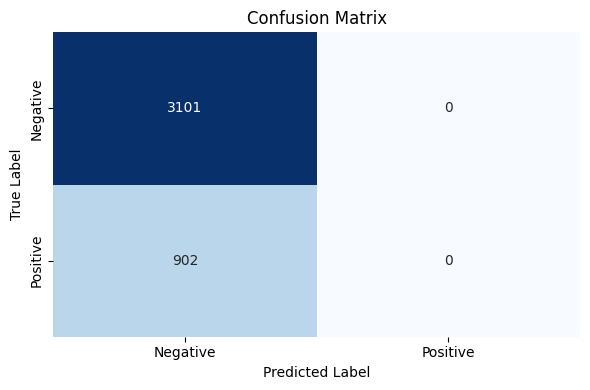

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# true_labels and predicted_labels must be 1D arrays of 0/1
# (you already computed these correctly earlier)

cm = confusion_matrix(true_labels, predicted_labels)

classes = ["Negative", "Positive"]  # adjust if needed

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=classes,
    yticklabels=classes
)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
